## PART 1: import the data and neccesary packages

In [1]:
#Resources of titles -- 538, upshot, etc. 
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd

pd.options.display.max_columns=None
pd.options.display.max_rows=100

#Install data from OpenBeta.  
df = pd.read_pickle("../InputData/Curated_OpenBetaAug2020_RytherAnderson.pkl.zip")


In [2]:
df.head(5)

,route_name,parent_sector,route_ID,sector_ID,type_string,fa,YDS,Vermin,nopm_YDS,nopm_Vermin,YDS_rank,Vermin_rank,safety,parent_loc,description,location,protection
0,Wheres Waldo?,Waldo's Rock Park,118170758,118170033,boulder,unknown,None,V2,None,V2,NaN,21.0,,"[-91.54207, 42.02717]",[Sit Start on the crack. Pull a big move to a ...,,[Pads]
2,Vanished Edens,Hot Stuff Camp Roof,117944541,117944427,boulder,"Joe Feldman, 2019",None,V4,None,V4,NaN,41.0,,"[-91.5615, 42.6154]",[Start right hand in a sidepull slot and left ...,[Hot Stuff Camp Roof],[pad - good landing]
3,Stairway to Heaven,Drive In Wall,106956280,106947227,trad,unknown,5.7,None,5.7,None,73.0,NaN,,"[-91.5625, 42.614]",[Climb the large flake right of Slot Machine t...,,"[SR, tricams are handy.]"
6,Cake Walk,Cake Walk and Razor Wall,106956306,106947239,trad,unknown,5.0,None,5.0,None,3.0,NaN,,"[-91.5625, 42.614]",[Obvious chimney half way up the gully. Sever...,,[SR]
7,Spinal Tap,Drive In Wall,106956299,106947227,trad,unknown,5.7+,None,5.7/8,None,75.0,NaN,,"[-91.5625, 42.614]",[Vertical hand crack to the right of Stairway ...,,[SR]


In [3]:
#Drop some variables we don't need
df=df.drop(columns=["YDS_rank", "Vermin_rank", "safety", "location", "protection"])

#Rename some variables
df=df.rename(columns={
    "type_string":"route_type"
})


## PART 2A: Clean up the Long-Lat info

In [4]:
#Replace the parent_loc as a string so you can split it
df.parent_locB=df.parent_loc.astype(str)

#Pull out the first number and call that longitude
df["long"]=df.parent_locB.str.split(",").str.get(0)
df.long=df.long.str.replace("[", "", regex=False)
df.head()

#Pull out the second number and call that latitude
df["lat"]=df.parent_locB.str.split(",").str.get(1)
df.lat=df.lat.str.replace("]", "", regex=False)

#Check it looks ok
df.head(10)

/var/folders/fy/56t7kzwn4m196p75kksy9j5c0000gn/T/ipykernel_43754/1330249931.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.parent_locB=df.parent_loc.astype(str)


,route_name,parent_sector,route_ID,sector_ID,route_type,fa,YDS,Vermin,nopm_YDS,nopm_Vermin,parent_loc,description,long,lat
0,Wheres Waldo?,Waldo's Rock Park,118170758,118170033,boulder,unknown,None,V2,None,V2,"[-91.54207, 42.02717]",[Sit Start on the crack. Pull a big move to a ...,-91.54207,42.02717
2,Vanished Edens,Hot Stuff Camp Roof,117944541,117944427,boulder,"Joe Feldman, 2019",None,V4,None,V4,"[-91.5615, 42.6154]",[Start right hand in a sidepull slot and left ...,-91.5615,42.6154
3,Stairway to Heaven,Drive In Wall,106956280,106947227,trad,unknown,5.7,None,5.7,None,"[-91.5625, 42.614]",[Climb the large flake right of Slot Machine t...,-91.5625,42.614
6,Cake Walk,Cake Walk and Razor Wall,106956306,106947239,trad,unknown,5.0,None,5.0,None,"[-91.5625, 42.614]",[Obvious chimney half way up the gully. Sever...,-91.5625,42.614
7,Spinal Tap,Drive In Wall,106956299,106947227,trad,unknown,5.7+,None,5.7/8,None,"[-91.5625, 42.614]",[Vertical hand crack to the right of Stairway ...,-91.5625,42.614
8,Slot Machine,Drive In Wall,106956271,106947227,trad,unknown,5.8,None,5.8,None,"[-91.5625, 42.614]",[Large off-width/squeeze chimney in the center...,-91.5625,42.614
10,Lefty and Poncho,Drive In Wall,106956212,106947227,trad,unknown,5.10b,None,5.10b,None,"[-91.5625, 42.614]",[Diagonal hand crack that starts on the left s...,-91.5625,42.614
12,A-Wall,Drive In Wall,106956228,106947227,trad,unknown,5.10a,None,5.10a,None,"[-91.5625, 42.614]",[Vertical hand crack right of the diagonal cra...,-91.5625,42.614
13,Hot Stuff,Hot Stuff Camp Roof,117944498,117944427,boulder,"Joe Feldman, 2019",None,V3-,None,V2/3,"[-91.5615, 42.6154]",[Start right hand jug sidepull in the crack an...,-91.5615,42.6154
15,Waldo went to Yosemite,Waldo's Rock Park,118182663,118170033,boulder,unknown,None,V1,None,V1,"[-91.54207, 42.02717]",[Stand Start on the obvious side pulling jugs....,-91.54207,42.02717


## PART 2B: Clean up ratings info into something sortable

In [5]:
#List all values of YDS
df.YDS.unique()

#VERSION 1: convert everything to rankable numeric.  Strip the 5. so 5.7 becomes 7.5, 
#w/ the .5 to signify that it is in the middle of the 7 range. 
#a is .2; b is .4; c is .6, d=.8
#a/b is .3; c/d is .7; - is .3; + is .7
#regular numbers are .5
df["yds_clean"]=df.YDS.replace({
    "5.0": 0.5,
    "5.1": 1.5,
    "5.2": 2.5,
    "5.3": 3.5,
    "5.4": 4.5,
    "5.5": 5.5,
    "5.6": 6.5,
    "5.7": 7.5,
    "5.8": 8.5,
    "5.9": 9.5,
    "5.10": 10.5,
    "5.11": 11.5,
    "5.12": 12.5,
    "5.13": 13.5,
    "5.14": 14.5,
    "5.15": 15.5,
    
    "5.5-": 5.3,
    "5.6-": 6.3,
    "5.7-": 7.3,
    "5.8-": 8.3,
    "5.9-": 9.3,
    "5.10-": 10.3,
    "5.11-": 11.3,
    "5.12-": 12.3,
    "5.13-": 13.3,
    "5.14-": 14.3,
    "5.15-": 15.3,

    "5.5+": 5.7,
    "5.6+": 6.7,
    "5.7+": 7.7,
    "5.8+": 8.7,
    "5.9+": 9.7,
    "5.10+": 10.7,
    "5.11+": 11.7,
    "5.12+": 12.7,
    "5.13+": 13.7,
    "5.14+": 14.7,
    "5.15+": 15.7,
    
    "5.5a": 5.2,
    "5.6a": 6.2,
    "5.7a": 7.2,
    "5.8a": 8.2,
    "5.9a": 9.2,
    "5.10a": 10.2,
    "5.11a": 11.2,
    "5.12a": 12.2,
    "5.13a": 13.2,
    "5.14a": 14.2,
    "5.15a": 15.2,
    
    "5.5a/b": 5.3,
    "5.6a/b": 6.3,
    "5.7a/b": 7.3,
    "5.8a/b": 8.3,
    "5.9a/b": 9.3,
    "5.10a/b": 10.3,
    "5.11a/b": 11.3,
    "5.12a/b": 12.3,
    "5.13a/b": 13.3,
    "5.14a/b": 14.3,
    "5.15a/b": 15.3,
    
    "5.5b": 5.4,
    "5.6b": 6.4,
    "5.7b": 7.4,
    "5.8b": 8.4,
    "5.9b": 9.4,
    "5.10b": 10.4,
    "5.11b": 11.4,
    "5.12b": 12.4,
    "5.13b": 13.4,
    "5.14b": 14.4,
    "5.15b": 15.4,
    
    "5.5b/c": 5.5,
    "5.6b/c": 6.5,
    "5.7b/c": 7.5,
    "5.8b/c": 8.5,
    "5.9b/c": 9.5,
    "5.10b/c": 10.5,
    "5.11b/c": 11.5,
    "5.12b/c": 12.5,
    "5.13b/c": 13.5,
    "5.14b/c": 14.5,
    "5.15b/c": 15.5,
    
    "5.5c": 5.6,
    "5.6c": 6.6,
    "5.7c": 7.6,
    "5.8c": 8.6,
    "5.9c": 9.6,
    "5.10c": 10.6,
    "5.11c": 11.6,
    "5.12c": 12.6,
    "5.13c": 13.6,
    "5.14c": 14.6,
    "5.15c": 15.6,
    
    "5.5c/d": 5.7,
    "5.6c/d": 6.7,
    "5.7c/d": 7.7,
    "5.8c/d": 8.7,
    "5.9c/d": 9.7,
    "5.10c/d": 10.7,
    "5.11c/d": 11.7,
    "5.12c/d": 12.7,
    "5.13c/d": 13.7,
    "5.14c/d": 14.7,
    "5.15c/d": 15.7,

    "5.5d": 5.8,
    "5.6d": 6.8,
    "5.7d": 7.8,
    "5.8d": 8.8,
    "5.9d": 9.8,
    "5.10d": 10.8,
    "5.11d": 11.8,
    "5.12d": 12.8,
    "5.13d": 13.8,
    "5.14d": 14.8,
    "5.15d": 15.8,
    None: np.nan
})

df.yds_clean=df.yds_clean.astype(float)
df.yds_clean.unique(), df.yds_clean.mean()

#VERSION 2: Generate a coarser rating without the decimals.  Keep the main number 5.8+ becomes 8
df["yds_clean_coarse"]=df["yds_clean"].apply(np.floor)
df.head(10)


#VERSION 3: Do the same thing for Vermin ratings
df.nopm_Vermin.unique()
df["ver_clean"]=df.nopm_Vermin.str.replace("V", "",  regex=False)
df.ver_clean.unique()

df.ver_clean=df.ver_clean.replace({
    "B": 0,
    "0/1": 2.5,
    "1/2": 1.5,
    "2/3": 2.5,
    "3/4": 3.5,
    "4/5": 4.5,
    "5/6": 5.5,
    "6/7": 6.5,
    "7/8": 7.5,
    "8/9": 8.5,
    "9/10": 9.5,
    "10/11": 10.5,
    "11/12": 11.5,
    "12/13": 12.5,
    "13/14": 13.5,
    "14/15": 14.5,
    "15/16": 15.5,
    None: np.nan
})

df.ver_clean=df.ver_clean.astype(float)

#VERSION 4: Generate a coarser rating without the decimals. 
df["ver_clean_coarse"]=df["ver_clean"].apply(np.floor)
df.head(10)

df.ver_clean_coarse.unique(), df.ver_clean.mean()


(array([ 2.,  4., nan,  1.,  3.,  0.,  6.,  5.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 16., 15., 17.]),
 3.3765120543750737)

## PART 3: Generate the word lists and word matches

In [30]:
#Write a function that takes in a route name and checks if it matches a predetermined list of words
def contains(route_name, word_list):
    for word in word_list:
        #This checks if the string word is in the string route_name
        if word.lower() in route_name.lower():
            return True
    return False

#VER 2 -- GET THE MATCH LIST
def matches(route_name, word_list):
    matched_words=[]
    for word in word_list:
        #This checks if the string word is in the string route_name
        if word.lower() in route_name.lower():
            matched_words.append(word.lower())
    return matched_words

#Here is the predetermined list of words
word_lists = {
    
    #any degrogatory word that generally refers to women
    "f": ['bimbo', 'slut', 'cunt', 'bitch', 'pussy', 'nagging', 'whore', 'girlfriend', 'girlie', 'girly', 'wife',
           'skank', 'blonde', 'chick ', ' ho ', ' hoe ', 'shrill', 'dyke',
         'crone', 'shemale', 'golddigger', 'gold digger', 'feminazi', 'lesbo', 'virgin', 'bae', 'babe', 
         'sugar baby', 'suger momma', 'suger mama', 'sassy', 'loose women'],
     "fB": ['bimbo', 'slut', 'cunt', 'bitch', 'pussy', 'whore', 'skank', ' ho ', ' hoe ', 'dyke',
            'tits', 'titty', 'pussies', ' rape', 'roofie', 'beaver', 'vagina', 'boobs', 'breast', 'muff '
           'twat', 'honey hole', 'cooch'],
    
    #Specific instances for graphing 
    "bitch": ['bitch'],
    "pussy": ['pussy', 'pussies', 'beaver', 'vagina', 'cunt'],
    "whore": ['whore', ' ho ', ' hoe ', 'slut'],
    "virgin": ['virgin'],
    
    #any female anatomy
    "fanat": ['cunt', 'pussy', 'pussies', 'beaver', 'vagina', 'boobs', 'breast', 'slit ', 'muff ',
             'twat', 'tits', 'titty', 'honey hole', 'cooch', 'bikini', 'estrogen'],   
    #any degrogatory word that generally refers to men
    #taking out homo for now since they are homo erectus
    "m": ['bro ', 'macho', 'cocksucker', 'prick', 'wanker', 'asshole', 'himbo', 'soy boy', 'beta male', 'poof', 'fag', 'suger daddy'],
    
    #any male anatomy
    "manat": ['dick', 'prick', 'wanker', 'boner', 'cock ', ' balls', 'shaft', 
              'well-hung', 'well hung', 'limp', 'penis', 'phallus', 'pecker', 'testosterone'],
    
    "penis": ['dick', 'prick', 'boner', 'cock ', 'shaft', 'penis', 'phallus', 'pecker'],
    "mB": ['dick', 'prick', 'wanker', 'boner', 'cock ', ' balls', 'shaft', 
              'well-hung', 'well hung', 'limp ', 'penis', 'phallus', 'pecker', 'testosterone',
          'pecker'],
    
    #sex is any sexual act or gender neutral genital anatomy
    "sex": ['fuck',' anal', 'facial', 'sex', 'bondage', 'horny', 'hooker', 'escort', 'prostitute',
     'thrust', ' rape', ' rape ', 'butthole', 'spank', 'booty', 'asshole', 'raw dog', 'ejact', 'wank', 'booty', 'suck', ' cum', 'genital',
    'gasm', 'blow job', 'lingus', 'bdsm', 'virgin', 'doggy', 'missionary', 'cowgirl', 'wet dream',
           'blue ball', 'golden shower', 'little death', 'petit mort', 'S&M', 'gag reflex', 'toss the muffin', 'roofie', 'molest'],
    "rape": [' rape', 'roofie'],

    #terms related to lgbt-ish identity 
    "lgbt": ['fag', 'dyke', 'lesbo', 'lesbian', 'tranny', 'gay', 'poof', 'shemale', 'drag queen', 'drag king', 'queer', 'bisexual'],
    
    #terms related to ethnic identity.  I didn't write out the n word since I checked it earlier and its not there.  Black is too confusing for race vs. color
    "eth": ['asian', 'hispanic', 'ghetto', 'slave', 'sambo', 'negro', 'chinese', 'chink', 'jew ',
           'white trash'],
    
    #terms related to money
    "money": ['marx', 'communism', 'tax', 'money', 'cash', 'dough', 'crypto', 'capitalism', 'coin'],
    
    #terms related to non-sexual violence/weapons
    "violence": ['guns', 'murder', 'killer', 'robbery', 'knife', 'bazooka', 'missle', 'nuclear', 
                'bombing', 'massacre', 'genocide', 'homocide'],
    
    #terms related to drugs
    "drugs": ['drugs', 'cody', 'uppers', 'coke', 'downers',  'booze', ' pot ', 'heroin', 'cocaine', 'coke', 'meth', '8 ball', 'eight ball', 'mary jane',
             'mdma', 'mainline', 'xannies', 'xanny', 'ketamine', 'special k', 'drank', 'angel dust' ,'shrooms', 'whippets', 'dope', 'ganja', 
              'adderall', 'reefer', 'vodka', 'bourbon', 'tequila', 'mezcal'],

    #Terms related to climbing
    "climb": ['overhang', 'arete', 'crack', 'slab', 'roof ', 'dihedral'],
    
    #Terms related to climbing
    "overhang": ['overhang'],
    "slab": ['slab'],
    "crack": ['crack'],
    "arete": ['arete'],
    "roof": ['roof '],
    "dihedral": ['dihedral'],
    "crimp": ['crimp'],
    "jug": ['jug '],
    "flake": [' flake'],
}

#THIS CODE GETS THE MATCH AND OUTPUTS TRUE FALSE SERIES
for key, value in word_lists.items():
    df[f"has_{key}"] = df["route_name"].map(lambda rn: contains(rn, value))

#THIS CODE CREATES A LIST OF THE ACTUAL WORDS THAT MATCH
for key, value in word_lists.items():
    df[f"matched_{key}"] = df["route_name"].map(lambda rn: matches(rn, value))

from collections import Counter
word_counter = Counter()
stop_words = {'the', 'and','of','a','in','out', 'unknown', 'unnamed', '(aka', 'with', 'you', 'my', 'from','an','on','left','right','under','there','that','for','all','none'}
for route_name in df["route_name"]:
    for word in route_name.lower().split(" "):
        if len(word) > 2 and word not in stop_words:
            word_counter[word] += 1



[('crack', 4231),
 ('arete', 2554),
 ('route', 2223),
 ('unknown', 2159),
 ('face', 2081),
 ('traverse', 1913),
 ('problem', 1475),
 ('direct', 1290),
 ('slab', 1163),
 ('corner', 1064),
 ('man', 1061),
 ('black', 1023),
 ('unnamed', 898),
 ('big', 892),
 ('little', 825),
 ('your', 812),
 ('roof', 769),
 ('with', 765),
 ('(aka', 740),
 ('you', 725),
 ('one', 704),
 ('project', 684),
 ('line', 654),
 ('time', 610),
 ('high', 609),
 ('wall', 587),
 ('aka', 587),
 ('side', 586),
 ('north', 584),
 ('easy', 581),
 ('red', 578),
 ('rock', 562),
 ('west', 546),
 ('white', 532),
 ('not', 527),
 ('east', 522),
 ('chimney', 516),
 ('love', 516),
 ('green', 515),
 ('south', 514),
 ('variation', 497),
 ('dog', 494),
 ("don't", 490),
 ('boulder', 483),
 ('day', 476),
 ('two', 460),
 ('monkey', 456),
 ('back', 452),
 ('power', 449),
 ('flake', 448),
 ('good', 437),
 ('old', 436),
 ('way', 433),
 ('fire', 419),
 ('boy', 417),
 ('down', 416),
 ('dihedral', 407),
 ('sit', 403),
 ('blue', 400),
 ('mr.',

In [41]:

word_counter.most_common(800)

[('crack', 4231),
 ('arete', 2554),
 ('route', 2223),
 ('unknown', 2159),
 ('face', 2081),
 ('traverse', 1913),
 ('problem', 1475),
 ('direct', 1290),
 ('slab', 1163),
 ('corner', 1064),
 ('man', 1061),
 ('black', 1023),
 ('unnamed', 898),
 ('big', 892),
 ('little', 825),
 ('your', 812),
 ('roof', 769),
 ('with', 765),
 ('(aka', 740),
 ('you', 725),
 ('one', 704),
 ('project', 684),
 ('line', 654),
 ('time', 610),
 ('high', 609),
 ('wall', 587),
 ('aka', 587),
 ('side', 586),
 ('north', 584),
 ('easy', 581),
 ('red', 578),
 ('rock', 562),
 ('west', 546),
 ('white', 532),
 ('not', 527),
 ('east', 522),
 ('chimney', 516),
 ('love', 516),
 ('green', 515),
 ('south', 514),
 ('variation', 497),
 ('dog', 494),
 ("don't", 490),
 ('boulder', 483),
 ('day', 476),
 ('two', 460),
 ('monkey', 456),
 ('back', 452),
 ('power', 449),
 ('flake', 448),
 ('good', 437),
 ('old', 436),
 ('way', 433),
 ('fire', 419),
 ('boy', 417),
 ('down', 416),
 ('dihedral', 407),
 ('sit', 403),
 ('blue', 400),
 ('mr.',

In [7]:
#THIS CREATES CODE THAT CHECKS FOR ANY TERMS MATCHING

#First, test to make sure you understand this code.  
dftest = pd.DataFrame({"P": [True, False], "Q": [True, False], "R": [1, 2], "S": [False, False]})
dftest["newseries"]=dftest.any(axis='columns')
dftest["newseriesB"]=dftest[["P","S"]].any(axis='columns')
dftest

#Now run it in our datafram.
df["has_any"]=df[["has_f", "has_fB", "has_fanat","has_m","has_manat", "has_sex","has_eth","has_lgbt","has_money","has_drugs", "has_arete", "has_slab", "has_overhang", "has_dihedral", "has_roof", "has_jug", "has_crimp", "has_flake"]].any(axis='columns')
df["has_fall"]=df[["has_f","has_fanat"]].any(axis='columns')
df["has_fBall"]=df[["has_fB","has_fanat"]].any(axis='columns')
df["has_fallsex"]=df[["has_f","has_fanat","has_sex"]].any(axis='columns')
df["has_mall"]=df[["has_m","has_manat"]].any(axis='columns')
df["has_mallsex"]=df[["has_m","has_manat","has_sex"]].any(axis='columns')
df["has_fmallsex"]=df[["has_m","has_manat","has_f","has_fanat","has_sex"]].any(axis='columns')
df.head()

,route_name,parent_sector,route_ID,sector_ID,route_type,fa,YDS,Vermin,nopm_YDS,nopm_Vermin,parent_loc,description,long,lat,yds_clean,yds_clean_coarse,ver_clean,ver_clean_coarse,has_f,has_fB,has_bitch,has_pussy,has_whore,has_virgin,has_fanat,has_m,has_manat,has_penis,has_mB,has_sex,has_rape,has_lgbt,has_eth,has_money,has_violence,has_drugs,has_climb,has_overhang,has_slab,has_crack,has_arete,has_roof,has_dihedral,has_crimp,has_jug,has_flake,matched_f,matched_fB,matched_bitch,matched_pussy,matched_whore,matched_virgin,matched_fanat,matched_m,matched_manat,matched_penis,matched_mB,matched_sex,matched_rape,matched_lgbt,matched_eth,matched_money,matched_violence,matched_drugs,matched_climb,matched_overhang,matched_slab,matched_crack,matched_arete,matched_roof,matched_dihedral,matched_crimp,matched_jug,matched_flake,has_any,has_fall,has_fBall,has_fallsex,has_mall,has_mallsex,has_fmallsex
0,Wheres Waldo?,Waldo's Rock Park,118170758,118170033,boulder,unknown,None,V2,None,V2,"[-91.54207, 42.02717]",[Sit Start on the crack. Pull a big move to a ...,-91.54207,42.02717,NaN,NaN,2.0,2.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],False,False,False,False,False,False,False
2,Vanished Edens,Hot Stuff Camp Roof,117944541,117944427,boulder,"Joe Feldman, 2019",None,V4,None,V4,"[-91.5615, 42.6154]",[Start right hand in a sidepull slot and left ...,-91.5615,42.6154,NaN,NaN,4.0,4.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],False,False,False,False,False,False,False
3,Stairway to Heaven,Drive In Wall,106956280,106947227,trad,unknown,5.7,None,5.7,None,"[-91.5625, 42.614]",[Climb the large flake right of Slot Machine t...,-91.5625,42.614,7.5,7.0,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],False,False,False,False,False,False,False
6,Cake Walk,Cake Walk and Razor Wall,106956306,106947239,trad,unknown,5.0,None,5.0,None,"[-91.5625, 42.614]",[Obvious chimney half way up the gully. Sever...,-91.5625,42.614,0.5,0.0,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],False,False,False,False,False,False,False
7,Spinal Tap,Drive In Wall,106956299,106947227,trad,unknown,5.7+,None,5.7/8,None,"[-91.5625, 42.614]",[Vertical hand crack to the right of Stairway ...,-91.5625,42.614,7.7,7.0,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],False,False,False,False,False,False,False


In [8]:

df.query("has_f==True").matched_f.value_counts()
#List the route names that match muff
#df.query("matched_fanat[0]=='muff'")


[bitch]                 147
[virgin]                 79
[pussy]                  76
[wife]                   42
[whore]                  36
[blonde]                 33
[babe]                   30
[slut]                   26
[dyke]                   25
[girlfriend]             24
[sassy]                  20
[skank]                  17
[chick ]                 17
[girly]                  11
[gold digger]             9
[girlie]                  7
[bimbo]                   7
[bae]                     6
[ ho ]                    5
[crone]                   2
[lesbo]                   2
[sugar baby]              1
[golddigger]              1
[bitch, virgin]           1
[girlfriend, virgin]      1
[cunt]                    1
[loose women]             1
[feminazi]                1
Name: matched_f, dtype: int64

In [9]:
df.query("has_manat==True").matched_manat.value_counts()

[dick]             144
[ balls]            83
[shaft]             49
[prick]             38
[cock ]             30
[pecker]            29
[penis]             23
[limp]              22
[boner]             21
[well hung]         10
[wanker]             9
[testosterone]       7
[phallus]            4
[dick, limp]         3
[cock ,  balls]      1
[well-hung]          1
Name: matched_manat, dtype: int64

In [10]:
df.query("has_sex==True").matched_sex.value_counts()

[sex]                206
[suck]               117
[virgin]              81
[booty, booty]        72
[fuck]                65
[spank]               55
[hooker]              51
[cowgirl]             40
[horny]               39
[gasm]                32
[wank]                28
[wet dream]           24
[bondage]             20
[thrust]              20
[golden shower]       20
[doggy]               18
[asshole]             16
[ anal]               14
[butthole]            13
[missionary]          12
[s&m]                 11
[facial]              10
[blue ball]            8
[roofie]               6
[gag reflex]           4
[ cum]                 4
[prostitute]           4
[genital]              3
[molest]               3
[ rape]                3
[raw dog]              3
[blow job]             3
[petit mort]           1
[fuck, asshole]        1
[bdsm]                 1
[sex, suck]            1
[little death]         1
[toss the muffin]      1
[spank, wank]          1
[fuck, suck]           1


In [40]:
#This code checks if a matched word has too many false pos
df[df['matched_sex'].apply(lambda x: ' rape' in x)].route_name.value_counts()

#df.query("has_sex==1").route_name.value_counts().head(20)

#Fix some -- like replace manat=False if Moby Dick
#if df['matched_manat'].apply(lambda x: 'dick' in x)==True:
   # df.has_manat=False


Little Rapes              1
Rooster Raper             1
Date Rape                 1
Land of Rape and Honey    1
Name: route_name, dtype: int64

In [12]:
#Convert everything to 0/1
varlist=["has_f", "has_fB", "has_rape", "has_fanat","has_m", "has_manat" ,"has_sex","has_eth","has_lgbt",
         "has_money","has_violence","has_drugs", "has_any", "has_fall", "has_fBall", "has_fallsex","has_mall", "has_mallsex",
         "has_fmallsex", "has_climb", "has_arete", "has_slab", "has_crack", "has_overhang", 
        "has_dihedral", "has_roof", "has_crimp", "has_jug", "has_any",
        "has_bitch", "has_pussy", "has_whore", "has_virgin", "has_penis", "has_flake"]
        
for var in varlist:
    #print(var)
    df[var] = df[var].astype(int)
    
    

In [13]:
#This allows us to inspect matches for specific types
df.query("has_fB==1")  

,route_name,parent_sector,route_ID,sector_ID,route_type,fa,YDS,Vermin,nopm_YDS,nopm_Vermin,parent_loc,description,long,lat,yds_clean,yds_clean_coarse,ver_clean,ver_clean_coarse,has_f,has_fB,has_bitch,has_pussy,has_whore,has_virgin,has_fanat,has_m,has_manat,has_penis,has_mB,has_sex,has_rape,has_lgbt,has_eth,has_money,has_violence,has_drugs,has_climb,has_overhang,has_slab,has_crack,has_arete,has_roof,has_dihedral,has_crimp,has_jug,has_flake,matched_f,matched_fB,matched_bitch,matched_pussy,matched_whore,matched_virgin,matched_fanat,matched_m,matched_manat,matched_penis,matched_mB,matched_sex,matched_rape,matched_lgbt,matched_eth,matched_money,matched_violence,matched_drugs,matched_climb,matched_overhang,matched_slab,matched_crack,matched_arete,matched_roof,matched_dihedral,matched_crimp,matched_jug,matched_flake,has_any,has_fall,has_fBall,has_fallsex,has_mall,has_mallsex,has_fmallsex
267,Honey Hole,Coralville Lake Bouldering,118879935,118879111,boulder,Austin Bullard,None,V3,None,V3,"[-93.5376, 41.935]",[Start left of Sugar Butt. Go up to a crimp an...,-93.5376,41.935,NaN,NaN,3.0,3.0,0,1,0,0,0,0,1,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[],[honey hole],[],[],[],[],[honey hole],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],1,1,1,1,0,0,1
833,Beaver Bones,E. Exam Wall,106814165,111701616,trad,unknown,5.9,None,5.9,None,"[-88.68637, 37.50668]",[Gear climb the left-facing dihedral.],-88.68637,37.50668,9.5,9.0,NaN,NaN,0,1,0,1,0,0,1,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[],[beaver],[],[beaver],[],[],[beaver],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],1,1,1,1,0,0,1
876,Beaver Eater Deluxe,Lake Boulders,109348476,109348453,boulder,unknown,None,V8,None,V8,"[-88.7187, 37.4975]",[Start same as Screaming Eagle but climb out r...,-88.7187,37.4975,NaN,NaN,8.0,8.0,0,1,0,1,0,0,1,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[],[beaver],[],[beaver],[],[],[beaver],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],1,1,1,1,0,0,1
885,Breast Melk,Peoria - Rocky Glen,114405586,114405527,boulder,Charlie Schneider,None,V5-6,None,V5/6,"[-89.65178, 40.69426]",[This route is top-ropeable from a tree but it...,-89.65178,40.69426,NaN,NaN,5.5,5.0,0,1,0,0,0,0,1,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[],[breast],[],[],[],[],[breast],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],1,1,1,1,0,0,1
1586,Oily Easter Beaver,C: PG Wall -Coal House Area,112894945,110006328,sport,Kerby cGhee 1990,5.12a,None,5.12a,None,"[-89.02746, 37.5188]",[Follow the bolts to reach the anchor],-89.02746,37.5188,12.2,12.0,NaN,NaN,0,1,0,1,0,0,1,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[],[beaver],[],[beaver],[],[],[beaver],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180736,Bitches Brew,(7) Heaven's Wall,110365491,106769430,trad,"03-19-2006 Jon Stewart, Amy Stewart, Jim Opdyc...",5.10a,None,5.10a,None,"[-122.21051, 45.56714]",[A two pitch route that starts up Stairway to ...,-122.21051,45.56714,10.2,10.0,NaN,NaN,1,1,1,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[bitch],[bitch],[bitch],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],1,1,1,1,0,0,1
180834,Opdyke's Crack,(3) Snake Wall,106958917,106453920,trad,"Jim Opdyke, Mike Jackson, 1984",5.9,None,5.9,None,"[-122.21137, 45.5667]","[""Stem up shattered corner above left side of ...",-122.21137,45.5667,9.5,9.0,NaN,NaN,1,1,0,0,0,0,0,0,0,0,False,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,[dyke],[dyke],[],[],[],[],[],[],[],[],[],[],[],[dyke],[],[],[],[],[crack],[],[],[crack],[],[],[],[],[],[],1,1,1,1,0,0,1
181335,Split Beaver,King Pins,108056569,105793798,trad,"Bill Robins, P

## PART 4: Basic analysis

### 0.  Bar chart of matches by type

504


(2234, 9992)

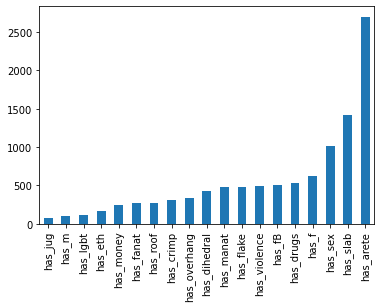

In [39]:
#Plot the means of a bunch of variables
df[["has_f", "has_fB", "has_fanat", "has_m", "has_manat", "has_sex", 
"has_eth", "has_lgbt", "has_drugs", "has_money","has_violence", "has_arete", "has_slab", "has_overhang", "has_dihedral", "has_roof", "has_jug", "has_crimp", "has_flake"]].sum().sort_values().plot(kind='bar')

print(df.has_fB.sum())
df.has_fmallsex.sum(), df.has_climb.sum()
#df[["has_fall", "has_mall", "has_sex", "has_eth", 
#    "has_lgbt", "has_drugs", "has_money","has_violence"]].mean().plot(kind='bar')


### 0.  Distribution of route difficulty

<AxesSubplot:>

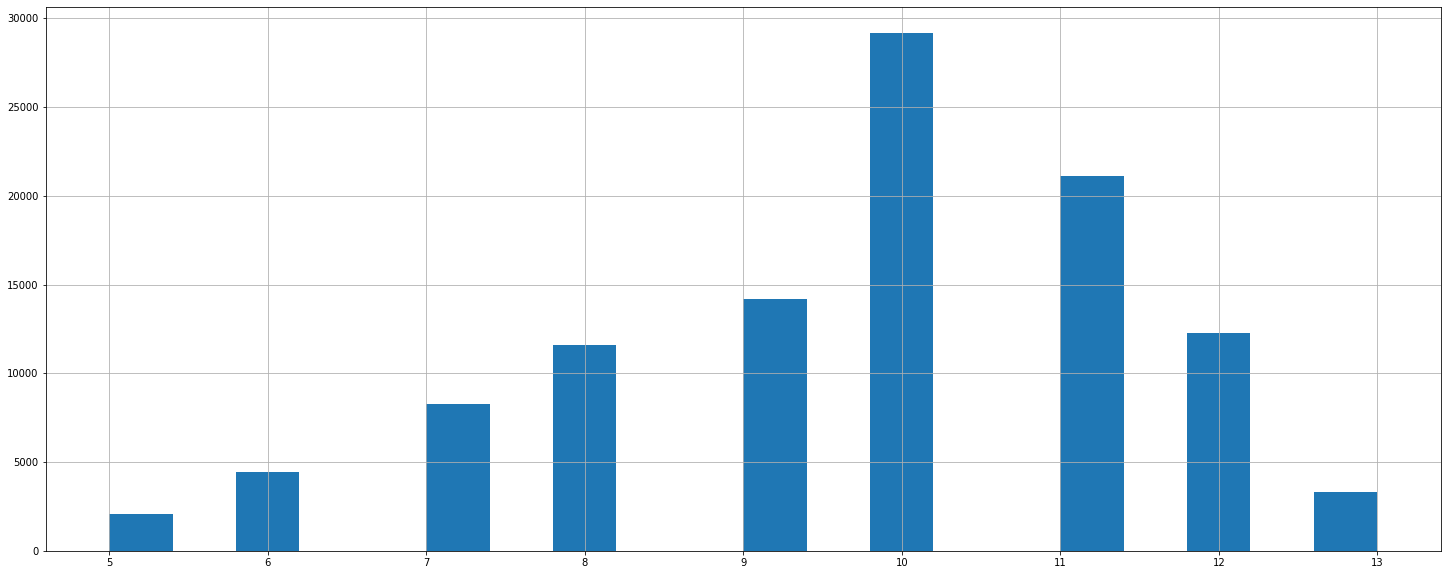

In [15]:
#A. Overall distribution of route difficulty -- YDS
df.query("yds_clean_coarse>=5 and yds_clean_coarse<=13").yds_clean_coarse.hist(bins=20, figsize=(25, 10))
#df.yds_clean_coarse.hist(bins=30, figsize=(25, 10))

#df.query("yds_clean_coarse>=5").groupby(by="yds_clean_coarse").nunique().plot(kind="bar", figsize=(25, 10))



### 1.  Average word-matchiness by route difficulty. 


<AxesSubplot:xlabel='yds_clean_coarse'>

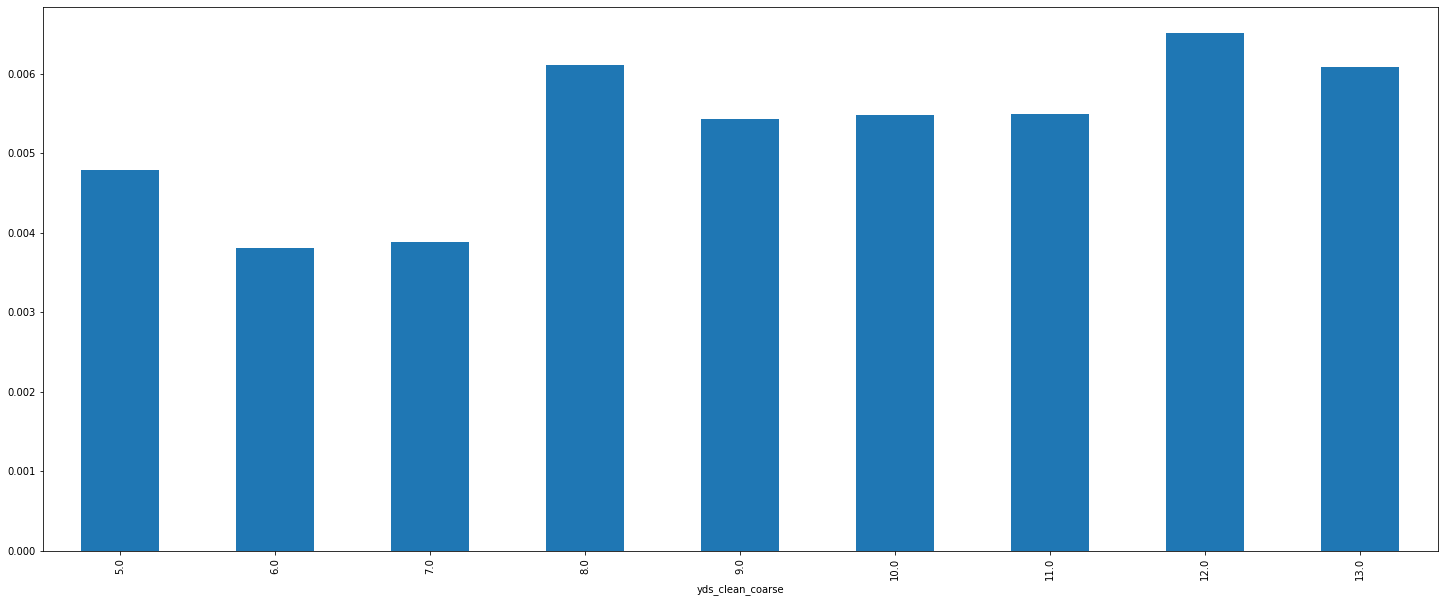

In [16]:
#A. Distribution of YDS matches by grade

#df.groupby(by="YDS").has_all.mean()
df.query("yds_clean_coarse>=5 and yds_clean_coarse<=13").groupby(by="yds_clean_coarse").has_fall.mean().plot(kind="bar", figsize=(25, 10))


<AxesSubplot:xlabel='yds_clean_coarse'>

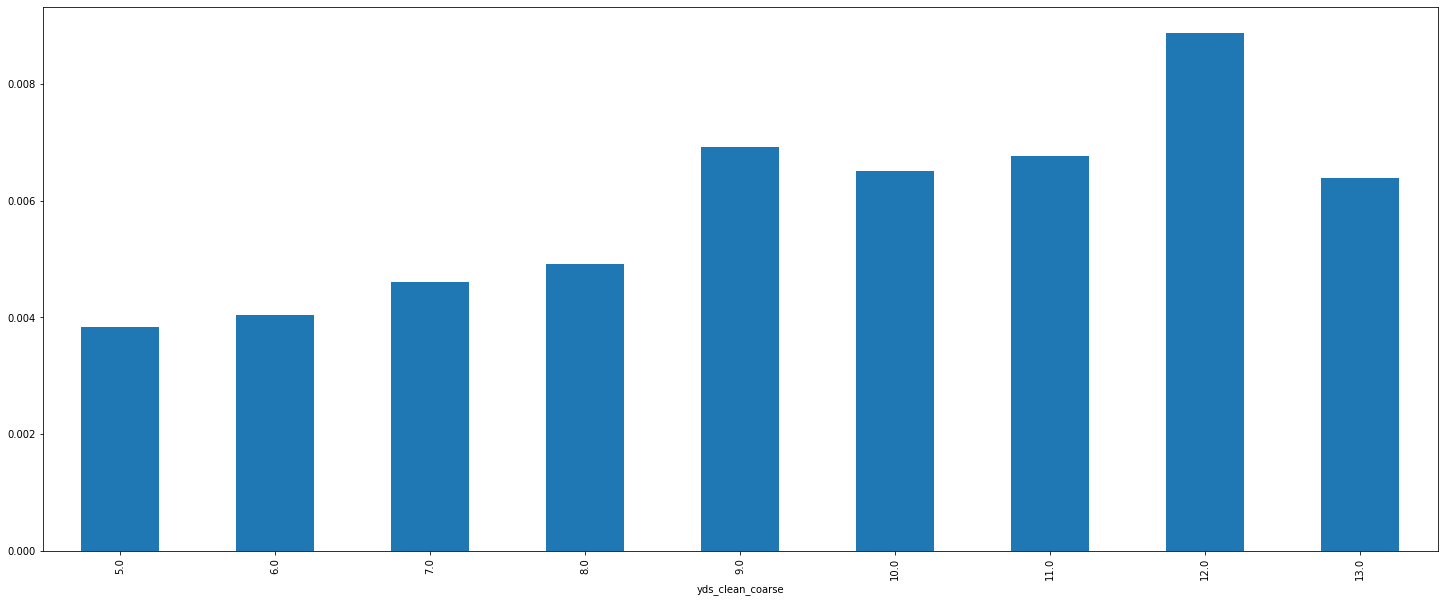

In [17]:
df.query("yds_clean_coarse>=5 and yds_clean_coarse<=13").groupby(by="yds_clean_coarse").has_sex.mean().plot(kind="bar", figsize=(25, 10))


<AxesSubplot:xlabel='yds_clean_coarse'>

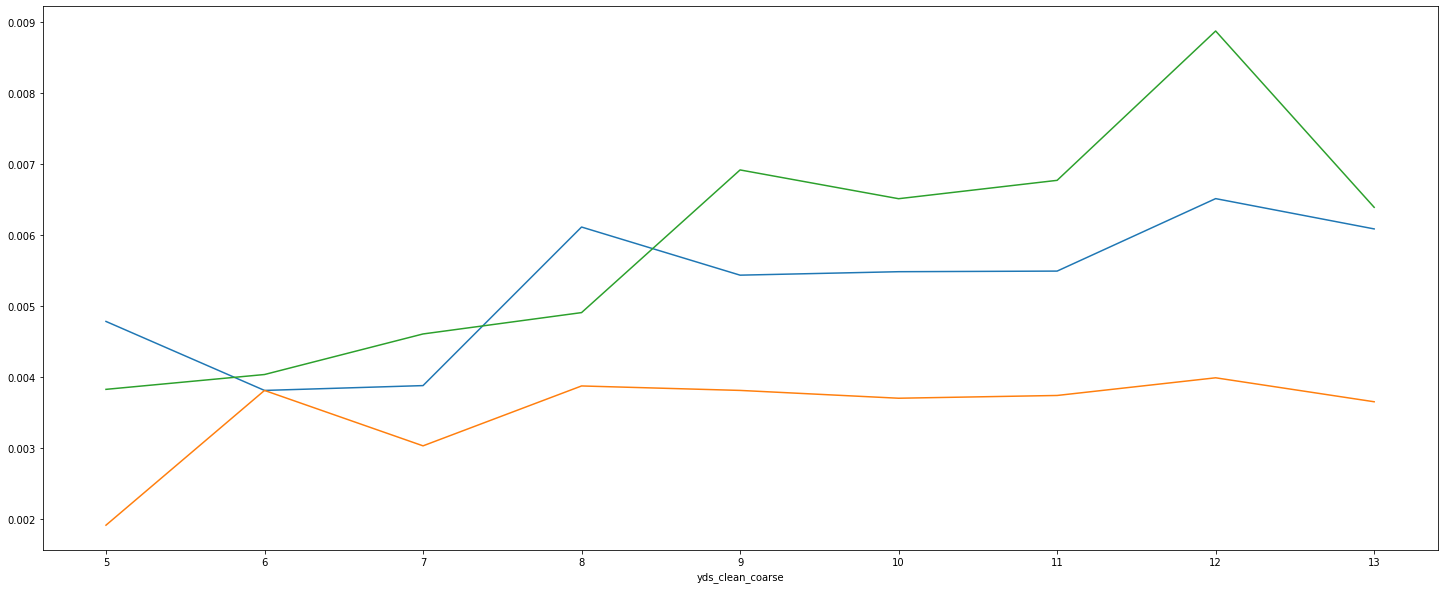

In [18]:
#Plot line graphs for dif series of has_m, has_f, has_sex, has_eth, etc.

plot_hasf=df.query("yds_clean_coarse>=5 and yds_clean_coarse<=13").groupby(by="yds_clean_coarse").has_fall.mean().plot(figsize=(25, 10))
plot_hasfm=df.query("yds_clean_coarse>=5 and yds_clean_coarse<=13").groupby(by="yds_clean_coarse").has_mall.mean().plot(ax=plot_hasf, figsize=(25, 10))
df.query("yds_clean_coarse>=5 and yds_clean_coarse<=13").groupby(by="yds_clean_coarse").has_sex.mean().plot(ax=plot_hasfm, figsize=(25, 10))



### 2.  Most common words in a category

### 3.  Maps 

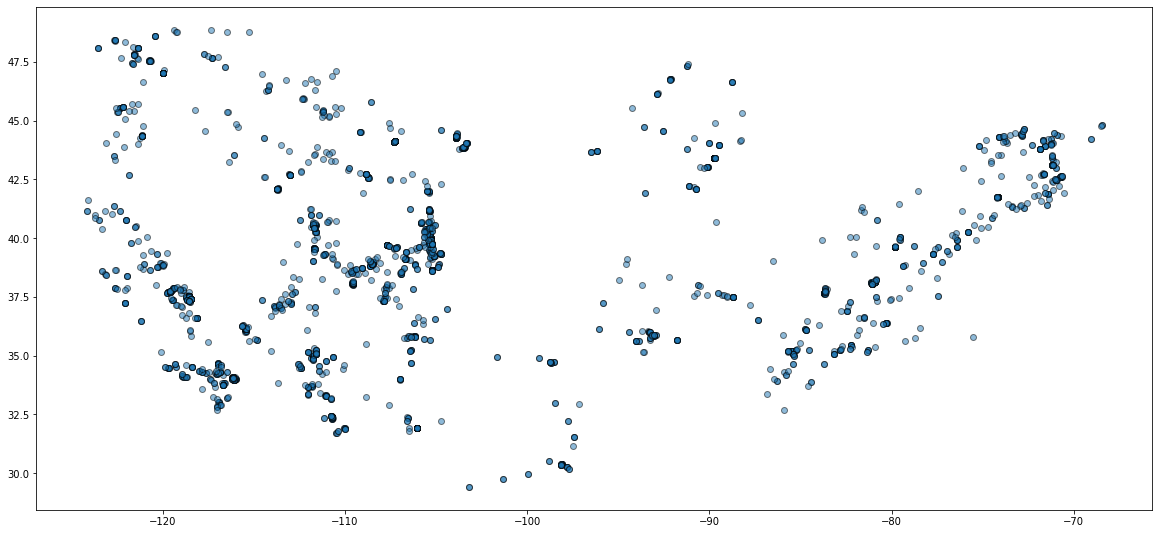

In [19]:
# convert [lng, lat] into shapely.geometry.Point
match_routes=df.query("has_fmallsex==1")
route_locs = [Point(tuple(xy)) for xy in match_routes["parent_loc"]]
#print(route_locs)

#Plot the map
geo_df = gpd.GeoDataFrame(match_routes, crs="EPSG:4326", geometry=route_locs)
ax = geo_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')



## PART 4:  Output dataframes for Datawrapper. 

In [20]:
df.head()

,route_name,parent_sector,route_ID,sector_ID,route_type,fa,YDS,Vermin,nopm_YDS,nopm_Vermin,parent_loc,description,long,lat,yds_clean,yds_clean_coarse,ver_clean,ver_clean_coarse,has_f,has_fB,has_bitch,has_pussy,has_whore,has_virgin,has_fanat,has_m,has_manat,has_penis,has_mB,has_sex,has_rape,has_lgbt,has_eth,has_money,has_violence,has_drugs,has_climb,has_overhang,has_slab,has_crack,has_arete,has_roof,has_dihedral,has_crimp,has_jug,has_flake,matched_f,matched_fB,matched_bitch,matched_pussy,matched_whore,matched_virgin,matched_fanat,matched_m,matched_manat,matched_penis,matched_mB,matched_sex,matched_rape,matched_lgbt,matched_eth,matched_money,matched_violence,matched_drugs,matched_climb,matched_overhang,matched_slab,matched_crack,matched_arete,matched_roof,matched_dihedral,matched_crimp,matched_jug,matched_flake,has_any,has_fall,has_fBall,has_fallsex,has_mall,has_mallsex,has_fmallsex
0,Wheres Waldo?,Waldo's Rock Park,118170758,118170033,boulder,unknown,None,V2,None,V2,"[-91.54207, 42.02717]",[Sit Start on the crack. Pull a big move to a ...,-91.54207,42.02717,NaN,NaN,2.0,2.0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],0,0,0,0,0,0,0
2,Vanished Edens,Hot Stuff Camp Roof,117944541,117944427,boulder,"Joe Feldman, 2019",None,V4,None,V4,"[-91.5615, 42.6154]",[Start right hand in a sidepull slot and left ...,-91.5615,42.6154,NaN,NaN,4.0,4.0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],0,0,0,0,0,0,0
3,Stairway to Heaven,Drive In Wall,106956280,106947227,trad,unknown,5.7,None,5.7,None,"[-91.5625, 42.614]",[Climb the large flake right of Slot Machine t...,-91.5625,42.614,7.5,7.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],0,0,0,0,0,0,0
6,Cake Walk,Cake Walk and Razor Wall,106956306,106947239,trad,unknown,5.0,None,5.0,None,"[-91.5625, 42.614]",[Obvious chimney half way up the gully. Sever...,-91.5625,42.614,0.5,0.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],0,0,0,0,0,0,0
7,Spinal Tap,Drive In Wall,106956299,106947227,trad,unknown,5.7+,None,5.7/8,None,"[-91.5625, 42.614]",[Vertical hand crack to the right of Stairway ...,-91.5625,42.614,7.7,7.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],0,0,0,0,0,0,0


In [21]:
df_export = df[['lat', 'long', 'yds_clean_coarse', 'ver_clean_coarse', 'fa', 'route_name', 'nopm_YDS', 'nopm_Vermin', "has_f", "has_fB", "has_fanat", "has_fall", "has_fBall", "has_fallsex", "has_m", "has_manat", "has_mall", "has_mallsex", "has_sex", "has_fmallsex",
"has_eth", "has_lgbt", "has_drugs", "has_money","has_violence",
                'has_penis', 'has_bitch', 'has_pussy', 'has_whore', 'has_virgin',
                 "has_arete", "has_slab", "has_overhang", "has_dihedral", "has_roof", "has_jug", "has_crimp", "has_flake", "has_any"]]

#Make a beginner, intermediate, adv, expert rating
#https://www.mec.ca/en/explore/climbing-grade-conversion
#Beginner=<=5.7
#Intermediate=5.8-5.10, V0, V1
#Adv=5.11, 5.12, V2-V6
#Exp 5.13+, V7+
#df_export.loc[df_export.yds_clean_coarse<=7, 'rating'] = "Beginner"
#df_export.loc[(df_export.yds_clean_coarse>=8 and df_export.yds_clean_coarse<=10), 'rating'] = "Beginner"
df_export['rating']=""
df_export['rating'] = np.where((df_export.yds_clean_coarse<=7),'Beginner', df_export.rating)
df_export['rating'] = np.where((df_export.yds_clean_coarse>=8) & (df_export.yds_clean_coarse<=10),'Intermediate', df_export.rating)
df_export['rating'] = np.where((df_export.yds_clean_coarse>=11),'Advanced', df_export.rating)
df_export['rating'] = np.where((df_export.ver_clean_coarse>=0) & (df_export.ver_clean_coarse<=2),'Intermediate', df_export.rating)
df_export['rating'] = np.where((df_export.ver_clean_coarse>=3),'Advanced', df_export.rating)

df_export.head(10)


/var/folders/fy/56t7kzwn4m196p75kksy9j5c0000gn/T/ipykernel_43754/3470264669.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export['rating']=""
/var/folders/fy/56t7kzwn4m196p75kksy9j5c0000gn/T/ipykernel_43754/3470264669.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export['rating'] = np.where((df_export.yds_clean_coarse<=7),'Beginner', df_export.rating)
/var/folders/fy/56t7kzwn4m196p75kksy9j5c0000gn/T/ipykernel_43754/3470264669.py:16: SettingWithCopyWarning: 
A value is trying to be set on

,lat,long,yds_clean_coarse,ver_clean_coarse,fa,route_name,nopm_YDS,nopm_Vermin,has_f,has_fB,has_fanat,has_fall,has_fBall,has_fallsex,has_m,has_manat,has_mall,has_mallsex,has_sex,has_fmallsex,has_eth,has_lgbt,has_drugs,has_money,has_violence,has_penis,has_bitch,has_pussy,has_whore,has_virgin,has_arete,has_slab,has_overhang,has_dihedral,has_roof,has_jug,has_crimp,has_flake,has_any,rating
0,42.02717,-91.54207,NaN,2.0,unknown,Wheres Waldo?,None,V2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Intermediate
2,42.6154,-91.5615,NaN,4.0,"Joe Feldman, 2019",Vanished Edens,None,V4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Advanced
3,42.614,-91.5625,7.0,NaN,unknown,Stairway to Heaven,5.7,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Beginner
6,42.614,-91.5625,0.0,NaN,unknown,Cake Walk,5.0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Beginner
7,42.614,-91.5625,7.0,NaN,unknown,Spinal Tap,5.7/8,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Beginner
8,42.614,-91.5625,8.0,NaN,unknown,Slot Machine,5.8,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Intermediate
10,42.614,-91.5625,10.0,NaN,unknown,Lefty and Poncho,5.10b,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Intermediate
12,42.614,-91.5625,10.0,NaN,unknown,A-Wall,5.10a,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Intermediate
13,42.6154,-91.5615,NaN,2.0,"Joe Feldman, 2019",Hot Stuff,None,V2/3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Intermediate
15,42.02717,-91.54207,NaN,1.0,unknown,Waldo went to Yosemite,None,V1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Intermediate


In [22]:

#ALL 
df_export.to_csv("../WorkingData/df_main.csv")
###
#FIGURE 1: MAP OF US WITH ROUTE NAMES -- USE FB
df_export.query("has_fB==1").to_csv("../FinalData/df_map.csv", index=False)
#BELOW NOT USED
# df_export.query("has_fBall==1").to_csv("../WorkingData/df_fBall.csv", index=False)
# df_export.query("has_f==1").to_csv("../WorkingData/df_f.csv", index=False)
# df_export.query("has_fall==1").to_csv("../WorkingData/df_fall.csv", index=False)
# df_export.query("has_fallsex==1").to_csv("../WorkingData/df_fallsex.csv", index=False)
# df_export.query("has_m==1").to_csv("../WorkingData/df_m.csv", index=False)
# df_export.query("has_mall==1").to_csv("../WorkingData/df_mall.csv", index=False)
# df_export.query("has_mallsex==1").to_csv("../WorkingData/df_mallsex.csv", index=False)
# df_export.query("has_fmallsex==1").to_csv("../WorkingData/df_fmallsex.csv", index=False)

#FIGURE 2: COUNTS OF WORDS RELATED TO TERMS 
#No rating info
df_short=df_export[["has_fall", "has_mall", "has_sex", "has_penis", "has_bitch", "has_pussy", "has_whore", "has_virgin", "has_arete", "has_slab", "has_overhang", "has_dihedral", "has_roof", "has_jug", "has_crimp", "has_flake"]].sum().sort_values()
df_short.to_csv("../FinalData/df_chart_norating.csv")

df_shortB=df_export.groupby(by="rating")[["has_fall", "has_mall", "has_sex", "has_penis", "has_bitch", "has_pussy", "has_whore", "has_virgin", "has_arete", "has_slab", "has_overhang", "has_dihedral", "has_roof", "has_jug", "has_crimp", "has_flake"]].sum().transpose()
df_shortB["total"]=df_shortB.Advanced+df_shortB.Intermediate+df_shortB.Beginner
df_shortB.to_csv("../FinalData/df_chart_rating.csv")
df_shortB.head()


#pd.set_option("display.max_rows", 100)

OSError: Cannot save file into a non-existent directory: '../WorkingData'

In [ ]:
df.head()

### Notes for sources in write up

Among indoor climbers, OIA’s data suggests a relatively even gender split with 58-percent men and 42-percent women. Outside, far more men climb (67 percent) than women (33 percent). Median age, percentage of participants who are married with children, is much the same.
https://sgbonline.com/study-reveals-climbings-powerful-impact/

